Environment and Libraries

In [1]:
import cv2
import os
import glob
import warnings
import scipy.misc
import numpy as np
# # import nibabel as nib
import SimpleITK as sitk
from scipy import ndimage
import matplotlib.pyplot as plt
# os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
from matplotlib.widgets import Slider

# import keras.api._v2.keras as keras
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import directed_hausdorff

Preprocessing Data

In [11]:
from preprocessing import preprocessing
import numpy as np
print('-'*30)
print('Loading and preprocessing training data...')
print('-'*30)

# \\files.auckland.ac.nz\research\resmed202100086-tws ----> Address for raw data
total_slices_raw_data = 1015
scans_path = 'D:/MRI - Tairawhiti'
# segmasks_fnames = ['1_R_tibia_15A', '2_R_tibia_16A', '3_R_tibia_4A']
# segmasks_fnames = ['6_R_tibia_9B', '7_R_tibia_10B', '8_R_tibia_12A', '9_R_tibia_11A', '10_R_tibia_13A']
# segmasks_fnames = ['6_R_tibia_9B', '7_R_tibia_10B', '8_R_tibia_12A']
segmasks_fnames = ['9_R_tibia_11A', '10_R_tibia_13A']
# segmasks_fnames = ['1_R_tibia_15A', '2_R_tibia_16A', '3_R_tibia_4A', '4_R_tibia_5A']
# segmasks_fnames = ['5_R_tibia_8A']
# segmasks_fnames = ['1_R_tibia_15A']
# scan_data_folders = np.array(['6_AutoBindWATER_650_9B', '7_AutoBindWATER_450_10B', '8_AutoBindWATER_450_12A', '9_AutoBindWATER_550_11A', '10_AutoBindWATER_450_13A'])
# scan_data_folders = np.array(['6_AutoBindWATER_650_9B', '7_AutoBindWATER_450_10B', '8_AutoBindWATER_450_12A'])
scan_data_folders = np.array(['9_AutoBindWATER_550_11A', '10_AutoBindWATER_450_13A'])
# scan_data_folders = ['1_AutoBind_WaterWATER_450_15A', '2_AutoBindWATER_450_16A', '3_AutoBindWATER_650_4A', '4_AutoBindWATER_750_5A']
# scan_data_folders = ['5_AutoBindWATER_1050_8A']
imgs_train, imgs_mask_train, raw_data  = preprocessing(scans_path, segmasks_fnames, scan_data_folders, total_slices_raw_data)

#Sample size (temp)
# imgs_train = imgs_train[:10, :, :, :]
# imgs_mask_train = imgs_mask_train[:10, :, :, :]

# Normalization
imgs_mask_train = imgs_mask_train.astype('float32')
imgs_train = imgs_train.astype('float32')
imgs_mask_train /= 255.  # scale masks to [0, 1]
imgs_train /= 255.  # scale masks to [0, 1]

imgs_train = np.reshape(imgs_train, (len(scan_data_folders) * total_slices_raw_data, 512, 512))
imgs_mask_train = np.reshape(imgs_mask_train, (len(segmasks_fnames) * total_slices_raw_data, 512, 512))
imgs_train = np.expand_dims(imgs_train, axis=-1)
imgs_mask_train = np.expand_dims(imgs_mask_train, axis=-1)

print("\n")
print('Final Training Image Input Shape: ', imgs_train.shape)
print('Final Training Mask Input Shape: ', imgs_mask_train.shape)

print('-'*30)
print('Completed Preprocessing Stage!')
print('-'*30)

------------------------------
Loading and preprocessing training data...
------------------------------
Patient Scan Data Folders Included in Run:  ['9_AutoBindWATER_550_11A' '10_AutoBindWATER_450_13A']


Segmentation Mask:  9_R_tibia_11A
Patient Scan Data:  9_AutoBindWATER_550_11A
Height of Paitent in mm:  1313.5
Length of Paitent AOI (tibia) in mm:  320.85565185546875
AOI Slice Start:  542
AOI Slice End:  755
AOI Slice Range:  214
Mask Slices Normalized to MRI Scans Shape (Purely AOI):  (214, 512, 512)




Segmentation Mask:  10_R_tibia_13A
Patient Scan Data:  10_AutoBindWATER_450_13A
Height of Paitent in mm:  1523.5
Length of Paitent AOI (tibia) in mm:  349.89306640625
AOI Slice Start:  768
AOI Slice End:  1001
AOI Slice Range:  234
Mask Slices Normalized to MRI Scans Shape (Purely AOI):  (234, 512, 512)




c:\Users\GGPC\OneDrive\Desktop\Part 4 Project\Part4Project\preprocessing.py:203: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_scans = np.array(training_scans)


Number of Paitents:  2
Training Scans Input Shape:  (2,)
Training Masks Input Shape:  (2, 1015, 512, 512)
Memory usage of training_scans: 0 MB.
Memory usage of train_mask_tibia_labels: 4060 MB.


ValueError: setting an array element with a sequence.

In [10]:
# Exporting Training Scan and Mask Data
import os 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def WriteOutTextFile(data_array, y_list, save_dir, starting_slice):
    num_files = data_array.shape[0]
    num_y = len(y_list)
    
    # Create the save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for i in range(num_files):
        file_name = f"data_{i + starting_slice}.txt"
        file_path = save_dir + '/' + file_name
        np.savetxt(file_path, data_array[i], delimiter=',', fmt='%.4f')
        print(f"Saved {file_path}")


def WriteOutImagePNGFiles(data_array, y_list, save_dir, starting_slice):
    num_files = data_array.shape[0]
    num_y = len(y_list)

    # Create the save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i in range(num_files):
        file_name = f"image_{i + starting_slice}.png"
        file_path = save_dir + '/' + file_name
            
        # Scale the pixel values to the range [0, 255] if necessary
        image_data = ((data_array[i] * 255).astype(np.uint8)).squeeze()
        # Create an Image object and save as PNG
        image = Image.fromarray(image_data)

        if True:
            image.save(file_path)
                
        print(f"Saved {file_path}")


# y_list = ['15A', '16A', '4A', '5A']   
# y_list = ['8A']
# y_list = ['9B', '10B', '12A', '11A', '13A']
y_list = ['9B', '10B', '12A']
starting_slice = 7978
save_directory_data_txt = 'D:/P4P Model Data/txt/Data'
save_directory_data_img = 'D:/P4P Model Data/img/Data'
save_directory_mask_txt = 'D:/P4P Model Data/txt/Masks'
save_directory_mask_img = 'D:/P4P Model Data/img/Masks'

WriteOutTextFile(imgs_train[:, :, :, 0], y_list, save_directory_data_txt, starting_slice)   
# WriteOutImagePNGFiles(imgs_train, y_list, save_directory_data_img)

WriteOutTextFile(imgs_mask_train[:, :, :, 0], y_list, save_directory_mask_txt, starting_slice)   
# WriteOutImagePNGFiles(imgs_mask_train, y_list, save_directory_mask_img)

Saved D:/P4P Model Data/txt/Data/data_4933.txt
Saved D:/P4P Model Data/txt/Data/data_4934.txt
Saved D:/P4P Model Data/txt/Data/data_4935.txt
Saved D:/P4P Model Data/txt/Data/data_4936.txt
Saved D:/P4P Model Data/txt/Data/data_4937.txt
Saved D:/P4P Model Data/txt/Data/data_4938.txt
Saved D:/P4P Model Data/txt/Data/data_4939.txt
Saved D:/P4P Model Data/txt/Data/data_4940.txt
Saved D:/P4P Model Data/txt/Data/data_4941.txt
Saved D:/P4P Model Data/txt/Data/data_4942.txt
Saved D:/P4P Model Data/txt/Data/data_4943.txt
Saved D:/P4P Model Data/txt/Data/data_4944.txt
Saved D:/P4P Model Data/txt/Data/data_4945.txt
Saved D:/P4P Model Data/txt/Data/data_4946.txt
Saved D:/P4P Model Data/txt/Data/data_4947.txt
Saved D:/P4P Model Data/txt/Data/data_4948.txt
Saved D:/P4P Model Data/txt/Data/data_4949.txt
Saved D:/P4P Model Data/txt/Data/data_4950.txt
Saved D:/P4P Model Data/txt/Data/data_4951.txt
Saved D:/P4P Model Data/txt/Data/data_4952.txt
Saved D:/P4P Model Data/txt/Data/data_4953.txt
Saved D:/P4P 

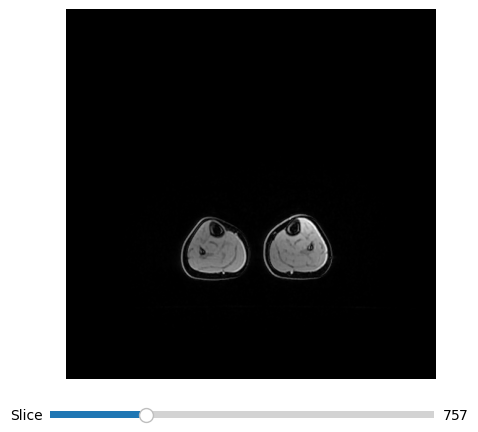

In [34]:
# Visualiser Tool Scan
temp = np.squeeze(imgs_train)
fig, ax = plt.subplots()
current_slice = 757
img = ax.imshow(temp[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, temp.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

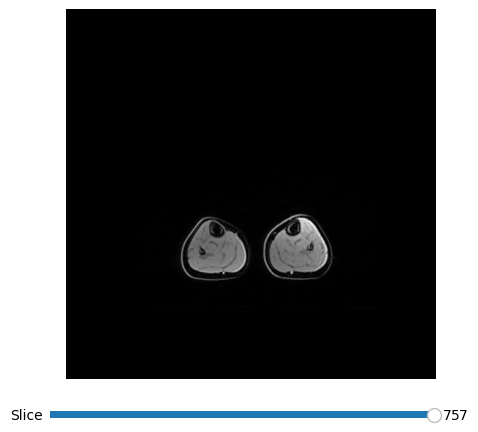

In [42]:
# temp = imgs_train[757].squeeze()
# np.savetxt('C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/testdata.txt', temp, delimiter=',', fmt='%.4f')
temp = np.loadtxt('C:/Users/GGPC/OneDrive/Desktop/Part 4 Project/Part4Project/testdata.txt', delimiter=',')
# print(temp.shape)
fig, ax = plt.subplots()
current_slice = 757
img = ax.imshow(temp, cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, current_slice, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

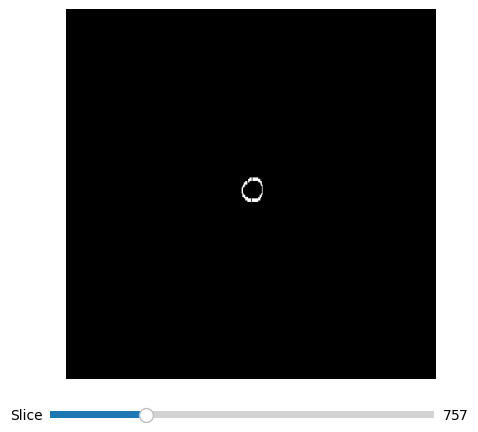

In [21]:
# Visualiser Tool Mask
temp = np.squeeze(imgs_mask_train)
fig, ax = plt.subplots()
current_slice = 757
img = ax.imshow(temp[current_slice], cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, temp.shape[0] - 1, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

NameError: name 'Slider' is not defined

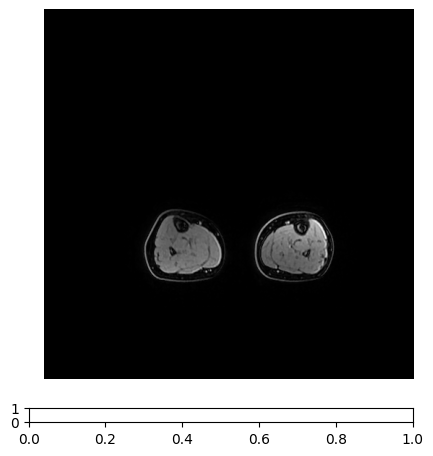

In [19]:
# temp = np.loadtxt("D:/P4P Model Data/txt/Data/data_1.txt", delimiter=',')
temp = np.loadtxt("D:/P4P Model Data/txt/Data/data_1800.txt", delimiter=',')
# Visualiser Tool Data Files
# temp = np.squeeze(imgs_mask_train)

# temp = temp.astype('float32')
# temp *= 255.

fig, ax = plt.subplots()
current_slice = 1000
img = ax.imshow(temp, cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, current_slice, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

NameError: name 'Slider' is not defined

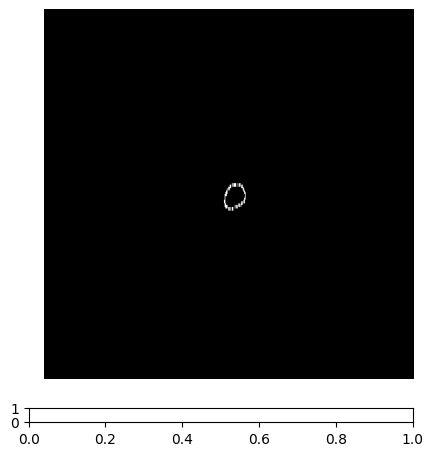

In [ ]:
# temp = np.loadtxt("D:/P4P Model Data/txt/Data/data_1.txt", delimiter=',')
temp = np.loadtxt("D:/P4P Model Data/txt/Masks/data_1800.txt", delimiter=',')
# Visualiser Tool Data Files
# temp = np.squeeze(imgs_mask_train)

# temp = temp.astype('float32')
# temp *= 255.

fig, ax = plt.subplots()
current_slice = 1500
img = ax.imshow(temp, cmap='gray')
ax.axis('off')

# Configure the slider
ax_slider = plt.axes([0.2, 0.02, 0.6, 0.03])
slider = Slider(ax_slider, 'Slice', 0, current_slice, valinit=current_slice, valstep=1)

def update_slice(val):
    current_slice = int(slider.val)
    img.set_data(temp[current_slice])
    fig.canvas.draw_idle()

slider.on_changed(update_slice)

plt.show()

UNet Model

In [27]:
def get_unet(scale = 0.5, dropout_rate = 0.4):
    inputs = keras.Input((512,512,1))

    # Encoding Path of the UNet (32-64-128-256-512)
    conv1   = Conv2D(32*scale, (3, 3), padding="same", activation='relu')(inputs)
    # conv1 = Conv2D(32*scale, 3, activation='relu', padding='same')(inputs)
    drop1   = Dropout(rate=dropout_rate)(conv1, training=True)
    max1    = MaxPooling2D((2, 2))(drop1)

    conv2   = Conv2D(64*scale, (3, 3), padding="same", activation='relu')(max1)
    drop2   = Dropout(rate=dropout_rate)(conv2, training=True)
    max2    = MaxPooling2D((2, 2))(drop2)

    conv3   = Conv2D(128*scale, (3, 3), padding="same", activation='relu')(max2)
    drop3   = Dropout(rate=dropout_rate)(conv3, training=True)
    max3    = MaxPooling2D((2, 2))(drop3)

    conv4   = Conv2D(256*scale, (3, 3), padding="same", activation='relu')(max3)
    drop4   = Dropout(rate=dropout_rate)(conv4, training=True)
    max4    = MaxPooling2D((2, 2))(drop4)

    lat     = Conv2D(512*scale, (3, 3), padding="same", activation='relu')(max4)
    drop5   = Dropout(rate=dropout_rate)(lat, training=True)

    # Decoding Path of the UNet
    up1     = UpSampling2D((2, 2))(drop5)
    concat1 = concatenate([conv4, up1], axis=-1)
    conv5   = Conv2D(256*scale, (3, 3), padding="same", activation='relu')(concat1)
    drop6   = Dropout(rate=dropout_rate)(conv5, training=True)
    
    up2     = UpSampling2D((2, 2))(drop6)
    concat2 = concatenate([conv3, up2], axis=-1)
    conv6   = Conv2D(128*scale, (3, 3), padding="same", activation='relu')(concat2)
    drop7   = Dropout(rate=dropout_rate)(conv6, training=True)
    
    up3     = UpSampling2D((2, 2))(drop7)
    concat3 = concatenate([conv2, up3], axis=-1)
    conv7   = Conv2D(64*scale, (3, 3), padding="same", activation='relu')(concat3)
    drop8   = Dropout(rate=dropout_rate)(conv7, training=True)

    up4     = UpSampling2D((2, 2))(drop8)
    concat4 = concatenate([conv1, up4], axis=-1)
    conv8   = Conv2D(32*scale, (3, 3), padding="same", activation='relu')(concat4)
    drop9   = Dropout(rate=dropout_rate)(conv8, training=True)
    
    outputs = Conv2D(1, (1, 1), activation="softmax")(drop9)

    model   = Model(inputs, outputs)

    return model

In [90]:
# Image Parameters
IMAGE_WDITH = 512
IMAGE_HEIGHT = 512
IMAGE_CHANNELS = 1

# Training, Testing and Validation Parameters
# TRAINING_VOLUMES = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# VALIDATION_VOLUMES = [9]

# Hyperparameters
N_CLASSES = 2
N_INPUT_CHANNELS = 1
# PATCH_SIZE = (32, 32)
# PATCH_STRIDE = (32, 32)

# # Data Preparation Parameters
# CONTENT_THRESHOLD = 0.3 # To Get Rid of Useless Information in the Image

# Training Parameters
N_EPOCHS = 200
BATCH_SIZE = 32
PATIENCE = 3
MODEL_FNAME_PATTERN = 'model.h5'
OPTIMISER = 'Adam'
# LOSS = 'categorical_crossentropy'
LOSS = 'binary_crossentropy'
dropout_rate = 0.40


print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)

images_train, images_val, labels_train, labels_val = train_test_split(imgs_train, imgs_mask_train, test_size=0.2, random_state=0)
print('Training Image Input Shape: ', images_train.shape)
print('Training Mask Input Shape: ', labels_train.shape)
print('Validation Image Input Shape: ', images_val.shape)
print('Validation Mask Input Shape: ', labels_val.shape)


print('-'*30)
print('Creating and compiling model...')
print('-'*30)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=PATIENCE), # early stopping
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_FNAME_PATTERN, save_best_only=True) # save the best based on validation
]

unet = get_unet()
unet.compile(optimizer=OPTIMISER, loss=LOSS)
unet.fit(
    x=images_train, 
    y=labels_train,
    validation_data=(images_val, labels_val),
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=my_callbacks,
    verbose=1)

unet.summary()

unet = get_unet()
unet.compile(optimizer=OPTIMISER, loss=LOSS)
unet.load_weights('model.h5')

testing_scans_processed = images_train[0]
testing_masks_processed = labels_train[0]
testing_scans_processed = np.reshape(testing_scans_processed, (1, 512, 512, 1))
testing_masks_processed = np.reshape(testing_masks_processed, (1, 512, 512, 1))

# testing_labels_processed = tf.keras.utils.to_categorical(testing_masks_processed, num_classes=2, dtype='float32')

print('Testing Image Input Shape: ',testing_scans_processed.shape)
print('Testing Mask Input Shape:',testing_masks_processed.shape)

prediction = unet.predict(x=testing_scans_processed)
# prediction = np.argmax(prediction, axis=3)
# prediction = np.reshape(prediction[0], (512, 512))

# plt.imshow(prediction, cmap='gray')
# plt.show()

------------------------------
Loading and preprocessing train data...
------------------------------
Training Image Input Shape:  (80, 512, 512, 1)
Training Mask Input Shape:  (80, 512, 512, 1)
Validation Image Input Shape:  (20, 512, 512, 1)
Validation Mask Input Shape:  (20, 512, 512, 1)
------------------------------
Creating and compiling model...
------------------------------
Epoch 1/200
3/3 [==============================] - 126s 39s/step - loss: 0.6529 - val_loss: 0.4214
Epoch 2/200


c:\Users\GGPC\anaconda3\envs\Py39-CNN\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 127s 40s/step - loss: 0.2659 - val_loss: 0.0502
Epoch 3/200
3/3 [==============================] - 126s 40s/step - loss: 0.0429 - val_loss: 0.0243
Epoch 4/200
3/3 [==============================] - 128s 41s/step - loss: 0.0183 - val_loss: 0.0108
Epoch 5/200
3/3 [==============================] - 132s 42s/step - loss: 0.0078 - val_loss: 0.0098
Epoch 6/200
3/3 [==============================] - 138s 42s/step - loss: 0.0072 - val_loss: 0.0106
Epoch 7/200
3/3 [==============================] - 130s 41s/step - loss: 0.0078 - val_loss: 0.0109
Epoch 8/200
3/3 [==============================] - 130s 41s/step - loss: 0.0078 - val_loss: 0.0100
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 512, 512, 1)]        0         []                            
    

In [92]:
np.mean(prediction)

1.0

In [88]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred, axis=(1, 2, 3))
    union = np.sum(y_true, axis=(1, 2, 3)) + np.sum(y_pred, axis=(1, 2, 3))
    dice = (2.0 * intersection) / (union + 1e-7)  # Adding a small epsilon to avoid division by zero
    return dice

def assd(y_true, y_pred, spacing):
    surface_distances = surface_distance(y_true, y_pred, spacing)
    avg_surface_distance = np.mean(surface_distances)
    return avg_surface_distance

def surface_distance(y_true, y_pred, spacing):
    true_surface = find_surface_points(y_true, spacing)
    pred_surface = find_surface_points(y_pred, spacing)
    
    if true_surface.shape[0] == 0 or pred_surface.shape[0] == 0:
        raise ValueError("One or both surface point arrays are empty.")
    
    try:
        surface_distances_true_to_pred = directed_hausdorff(true_surface, pred_surface)[0]
        surface_distances_pred_to_true = directed_hausdorff(pred_surface, true_surface)[0]
        surface_distances = np.concatenate([surface_distances_true_to_pred, surface_distances_pred_to_true])
    except ValueError as e:
        print("Error occurred during Hausdorff distance calculation:", e)
        raise
    
    return surface_distances

def find_surface_points(mask, spacing):
    mask_padded = np.pad(mask, 1, mode='constant')
    mask_padded_diff = np.diff(mask_padded.astype(int), axis=0)
    
    surface_points = []
    for z in range(mask_padded_diff.shape[0]):
        surface_indices = np.where(mask_padded_diff[z] != 0)
        if len(surface_indices[0]) > 0:
            surface_points.extend(list(zip(surface_indices[0], surface_indices[1])))
    
    surface_points = np.array(surface_points)
    surface_points_phys = surface_points * spacing
    
    return surface_points_phys

def volume_error(y_true, y_pred):
    true_volume = np.sum(y_true)
    pred_volume = np.sum(y_pred)
    volume_error = np.abs(true_volume - pred_volume) / true_volume
    return volume_error


DSC = dice_coefficient(testing_masks_processed, prediction)
print('Dice Similarity Coefficient (DSC) Metric Value: ', DSC)
print('\n')

# VError = volume_error(testing_masks_processed, prediction)
# print('Volume Error (VError) Metric Value: ', VError)
# print('\n')

# spacing = 1
# ASSD = assd(testing_masks_processed, prediction, spacing)
# print('Average Symmetric Surface Distance (ASSD) Metric Value: ', ASSD)
# print('\n')

Dice Similarity Coefficient (DSC) Metric Value:  [4.0989216e-06]




In [79]:
prediction.shape

(1, 512, 512, 1)

In [68]:
testing_masks_processed.shape

(1, 512, 512, 1)

(1, 512, 512, 1)
(1, 512, 512, 1)
1/1 [==============================] - 1s 688ms/step


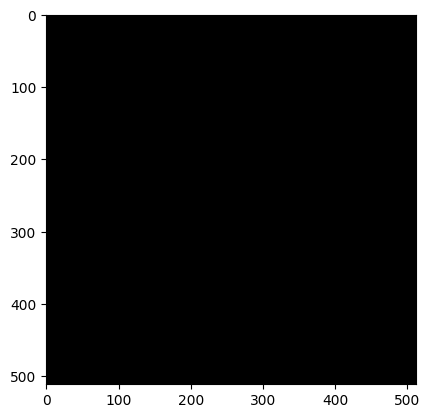

In [41]:
testing_scans_processed = images_train[0]
testing_masks_processed = labels_train[0]
testing_scans_processed = np.reshape(testing_scans_processed, (1, 512, 512, 1))
testing_masks_processed = np.reshape(testing_masks_processed, (1, 512, 512, 1))

testing_labels_processed = tf.keras.utils.to_categorical(testing_masks_processed, num_classes=2, dtype='float32')

print(testing_scans_processed.shape)
print(testing_masks_processed.shape)

prediction = unet.predict(x=testing_scans_processed)
prediction = np.argmax(prediction, axis=3)

prediction = np.reshape(prediction, (512, 512))

plt.imshow(prediction, cmap='gray')
plt.show()

In [35]:
testing_labels_processed

array([[[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       ...,

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]],

       [[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]], dtype=float32)

In [ ]:
# from keras.models import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Conv2DTranspose, concatenate
# from keras.layers.core import Dropout
# import tensorflow as tf
# # from tensorflow.keras.models import Model
# from keras.layers import *
# from keras.optimizers import Adam
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Define U-Net model
# def unet_model(input_shape):
#     inputs = Input(input_shape)
    
#     # Encoder
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
#     # Bottleneck
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
#     drop5 = Dropout(0.5)(conv5)
    
#     # Decoder
#     up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
#     merge6 = concatenate([drop4, up6], axis=3)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
#     up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
#     merge7 = concatenate([conv3, up7], axis=3)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
#     up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
#     merge8 = concatenate([conv2, up8], axis=3)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
#     up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
#     merge9 = concatenate([conv1, up9], axis=3)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
#     outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
#     model = Model(inputs=inputs, outputs=outputs)
    
#     return model

# # Dice Coefficient Loss Function 
# def dice_coefficient(y_true, y_pred):
#     smooth = 1e-5
#     intersection = tf.reduce_sum(y_true * y_pred)
#     union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return 1.0 - dice


# # Reformat image data structure
# training_scans_reshaped = np.concatenate(preprocessed_images, axis=0)
# training_scans = training_scans_reshaped.reshape((-1, 512, 512, 1))
# train_mask_tibia_labels_reshaped = np.concatenate(preprocessed_masks, axis=0)
# train_mask_tibia_labels = train_mask_tibia_labels_reshaped.reshape((-1, 512, 512, 1))

# # Split the data into training and validation sets\
# images_train, images_val, labels_train, labels_val = train_test_split(training_scans, train_mask_tibia_labels, test_size=0.2, random_state=0)
# unseen_scan_model = np.array(training_scans[2][100])
# images_train = images_train.astype('float32') / 255.0
# images_val = images_val.astype('float32') / 255.0

# print(images_train.shape)
# print(labels_train.shape)
# print(images_train.dtype)
# print(labels_train.dtype)
# print(images_val.shape)
# print(labels_val.shape)
# print(images_val.dtype)
# print(labels_val.dtype)
# print(unseen_scan_model.shape)

# # Expand dimensions for the channel (grayscale) dimension
# # images_train = np.expand_dims(images_train, axis=-1)
# # images_val = np.expand_dims(images_val, axis=-1)
# # labels_train = np.expand_dims(labels_train, axis=-1)
# # labels_val = np.expand_dims(labels_val, axis=-1)

# # Create an instance of the U-Net model
# input_shape = (512, 512, 1)  # For grayscale images

# # Create an instance of the U-Net model
# model = unet_model(input_shape)

# # Compile the model
# # Binary Cross Entropy Loss Function
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# # Dice Coefficient Loss Function
# # model.compile(optimizer=Adam(), loss=dice_coefficient, metrics=['accuracy'])

# # Train the model
# # Hyperparameter tuning -> batch_size
# model.fit(x=images_train, y=labels_train, batch_size=32, epochs=1, validation_data=(images_val, labels_val))
# # Evaluate the model
# loss, accuracy = model.evaluate(x=images_val, y=labels_val)

# # Perform inference on new, unseen MRI scans
# predictions = model.predict(unseen_scan_model)